In [7]:
from dptb.data import build_dataset

dataset = build_dataset(
    root="/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/test_siesta",
    
    
    prefix="data",
    type="LMDBDataset",

    get_Hamiltonian=True,
    get_overlap=True,
    basis={"Au":"2s1p2d"}
)

In [4]:
AtomicData = dataset[0]

In [7]:
from dptb.data import feature_to_block
from dptb.data import _keys
AtomicData[_keys.EDGE_FEATURES_KEY] = AtomicData[_keys.EDGE_OVERLAP_KEY]
AtomicData[_keys.NODE_FEATURES_KEY] = AtomicData[_keys.NODE_OVERLAP_KEY]

block = feature_to_block(AtomicData.to_dict(), idp=dataset.type_mapper)

In [8]:
from dptb.nn import Eigenvalues
from dptb.utils.make_kpoints import abacus_kpath
from dptb.data import _keys
from ase.io import read
from dptb.data import OrbitalMapper
import torch

AtomicData = dataset[0]
kpath = [[0., 0.,0.,20], 
                [0.0000000000,   0.5000000000,   0.0000000000,20],
                [0.5000000000,   0.5000000000,   0.0000000000,20], 
                [0.0000000000,   0.0000000000,   0.0000000000,20],
                [0.0000000000,   0.0000000000,   0.5000000000,20],
                [0.0000000000,   0.5000000000,   0.5000000000,20],
                [0.5000000000,   0.5000000000,   0.5000000000,20],
                [0.0000000000,   0.0000000000,   0.5000000000,20],
                [0.0000000000,   0.5000000000,   0.0000000000,20],
                [0.0000000000,   0.5000000000,   0.5000000000,20],
                [0.5000000000,   0.5000000000,   0.0000000000,20],
                [0.5000000000,   0.5000000000,   0.5000000000,1]]

structase = read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.xyz')
kpath_list, kdist_list, high_sym_kpoints = abacus_kpath(structase=structase, kpath=kpath)
eigs = Eigenvalues(
    idp=OrbitalMapper(basis={"Au":"2s1p2d"}),
    s_edge_field=_keys.EDGE_OVERLAP_KEY,
    s_node_field=_keys.NODE_OVERLAP_KEY,
    s_out_field=_keys.OVERLAP_KEY
    )

AtomicData[_keys.KPOINT_KEY] = torch.nested.as_nested_tensor([torch.from_numpy(kpath_list).float()])
AtomicData = eigs(AtomicData.to_dict())

# plt.plot(kdist_list, AtomicData[_keys.EIGENVALUES_KEY][0].numpy())

(-10.0, 10.0)

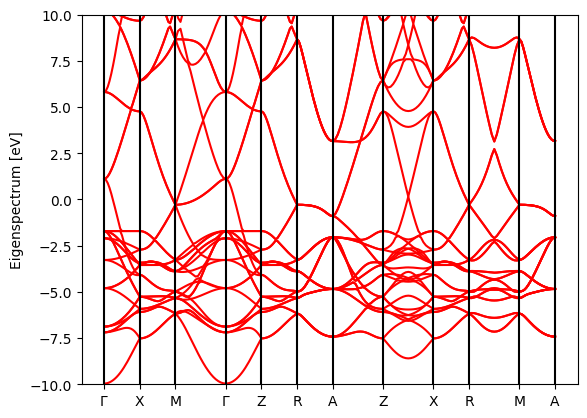

In [9]:
import numpy as np
import sisl
from ase.io import read, Trajectory
from sisl.physics.brillouinzone import BrillouinZone,MonkhorstPack
import matplotlib.pyplot as plt

eigs_all = []

H_fdf = sisl.Hamiltonian.read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.TSHS')

# bz = MonkhorstPack(H_fdf, [1,1,1])
# eigs = bz.apply.array.eigh()

band = sisl.BandStructure(H_fdf, [[0., 0.,0.], 
                [0.0000000000,   0.5000000000,   0.0000000000],
                [0.5000000000,   0.5000000000,   0.0000000000], 
                [0.0000000000,   0.0000000000,   0.0000000000],
                [0.0000000000,   0.0000000000,   0.5000000000],
                [0.0000000000,   0.5000000000,   0.5000000000],
                [0.5000000000,   0.5000000000,   0.5000000000],
                [0.0000000000,   0.0000000000,   0.5000000000],
                [0.0000000000,   0.5000000000,   0.0000000000],
                [0.0000000000,   0.5000000000,   0.5000000000],
                [0.5000000000,   0.5000000000,   0.0000000000],
                [0.5000000000,   0.5000000000,   0.5000000000]],
                [20,20,20,20,20,20,20,20,20,20,20],
                [r'$\Gamma$', 'X', 'M',r'$\Gamma$', 'Z','R', 'A','Z', 'X','R','M','A']) 
eigs_siesta = band.apply.array.eigh()
np.save("/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/test_siesta/eigs_siesta.npy", eigs_siesta)
# Retrieve the tick-marks and the linear k points
xtick, xtick_label = band.lineartick()
lk = band.lineark()
plt.plot(lk, eigs_siesta,'r')
plt.ylabel('Eigenspectrum [eV]')
plt.gca().xaxis.set_ticks(xtick)
plt.gca().set_xticklabels(xtick_label)

# Also plot x-major lines at the ticks
ymin, ymax = plt.gca().get_ylim()
for tick in xtick:
    plt.plot([tick,tick], [ymin,ymax], 'k')
# plt.hlines(0, 0, 6, colors='k', linestyles='dashed')
plt.ylim(-10,10)

(-10.0, 10.0)

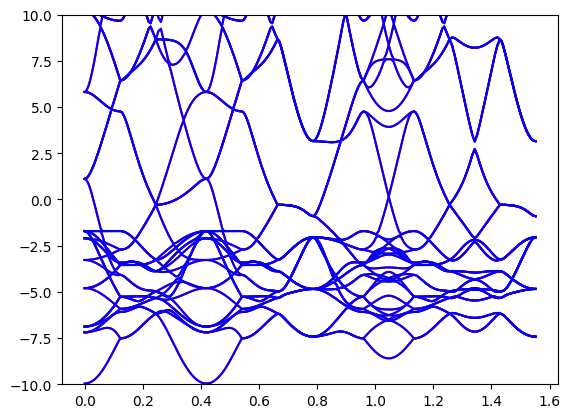

In [10]:
import numpy as np
band_siesta = np.load('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/test_siesta/eigs_siesta.npy')
plt.plot(kdist_list, AtomicData[_keys.ENERGY_EIGENVALUE_KEY][0].numpy(),'r')
plt.plot(kdist_list, band_siesta,'b')
plt.ylim(-10,10)

In [12]:
import sisl

ovp_sisl = sisl.Overlap.read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.HSX')
# ovp_sisl[0,0,(0,0,0)]
off = ovp_sisl.geometry.sc_index([0, 0, 0]) * ovp_sisl.geometry.no
off

0

In [91]:
import sisl

ovp_sisl = sisl.Overlap.read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.HSX')
ovp_csr = ovp_sisl.tocsr()

import matplotlib.pyplot as plt

for key_block in block.keys():
    key = key_block.split('_')
    iatom = int(key[0])
    jatom = int(key[1])
    Rvec = [int(key[i]) for i in range(2,5)]
    off = ovp_sisl.geometry.sc_index(Rvec) * ovp_sisl.no
    diff_block = ovp_csr[iatom*15:(iatom+1)*15,off+jatom*15:off+(jatom+1)*15].toarray()-block[key_block].numpy()
    if abs(diff_block).max() > 1e-5 and Rvec != [0,0,0]:
        print(key_block, abs(diff_block).max())
        # plt.matshow(diff_block, cmap="bwr", vmax=1.0, vmin=-1.0)
        # plt.show()
    
# plt.matshow(ovp_csr[:15,off:off+15].toarray()-block['0_0_0_-1_0'].numpy(), cmap="bwr", vmax=1.0, vmin=-1.0)
# plt.matshow(ovp_csr[:15,off:off+15].toarray().T-ovp_csr[:15,off2:off2+15].toarray(), cmap="bwr", vmax=1.0, vmin=-1.0)
# plt.show()

In [50]:
ovp_sisl.no

60

diff: 0.27749562


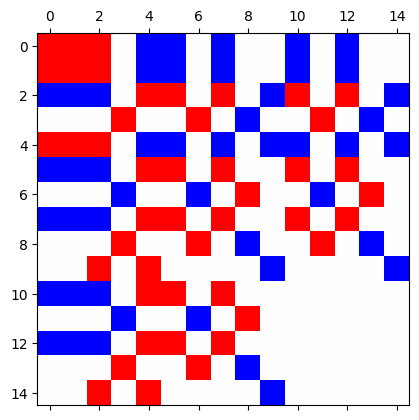

In [83]:

ovp_sisl = sisl.Overlap.read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.HSX')
ovp_csr = ovp_sisl.tocsr()
off = ovp_sisl.geometry.sc_index([-1,1,0]) * ovp_sisl.no
diff = abs(ovp_csr[15*2:15*3,15*3+off:15*4+off].toarray()-block['1_2_-1_1_0'].numpy()).max()
print('diff:',diff)
# plt.matshow(block['1_2_-1_1_0'].numpy(), cmap="bwr", vmax=0.00005, vmin=-0.00005)
# plt.matshow(ovp_csr[15*2:15*3,15*3+off:15*4+off].toarray(), cmap="bwr", vmax=0.00005, vmin=-0.00005)
# plt.matshow(ovp_csr[15*2:15*3,15*3+off:15*4+off].toarray()-block['1_2_-1_1_0'].numpy(), cmap="bwr", vmax=0.00005, vmin=-0.00005)
plt.matshow(ovp_csr[15*1:15*2,15*2+off:15*3+off].toarray(), cmap="bwr", vmax=0.00005, vmin=-0.00005)
plt.show()

# diff = abs(ovp_csr[15*1:15*2,15*2+off:15*3+off].toarray()-block['1_2_-1_1_0'].numpy()).max()
# print('diff:',diff)
# plt.matshow(ovp_csr[15*1:15*2,15*2+off:15*3+off].toarray()-block['1_2_-1_1_0'].numpy(), cmap="bwr", vmax=0.00005, vmin=-0.00005)
# plt.show()

diff: 0.0


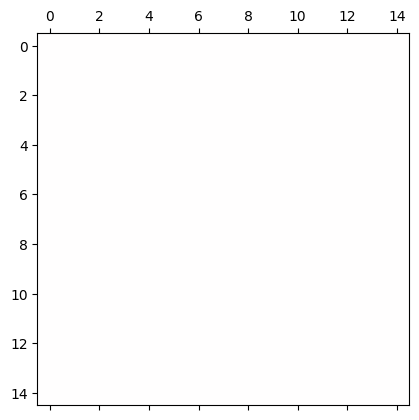

In [54]:
off = ovp_sisl.geometry.sc_index([-1,1,0]) * ovp_sisl.no
diff = abs(ovp_csr[15*2:15*3,15*3+off:15*4+off].toarray()-block['0_2_-1_1_0'].numpy()).max()
print('diff:',diff)
plt.matshow(ovp_csr[15*2:15*3,15*3+off:15*4+off].toarray()-block['1_2_-1_1_0'].numpy(), cmap="bwr", vmax=0.00005, vmin=-0.00005)
plt.show()

In [64]:
import numpy as np
import ase
ovp = sisl.Overlap.read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.HSX')
central_cell = [int(np.floor(ovp.nsc[i]/2)) for i in range(3)]
Rvec_list = []
for rx in range(ovp.nsc[0]):
    for ry in range(ovp.nsc[1]):
        for rz in range(ovp.nsc[2]):
            Rvec_list.append([rx-central_cell[0],ry-central_cell[1],rz-central_cell[2]])
Rvec = np.array(Rvec_list)


ovp_csr = ovp.tocsr()
ovp_blocks = []
for i in range(Rvec.shape[0]):
    off = ovp.geometry.sc_index(Rvec[i]) * ovp.no
    ovp_blocks.append(ovp_csr[:,off:off+ovp.no].toarray())
ovp_blocks = np.stack(ovp_blocks).astype(np.float32)

site_norbits = np.array([ovp.atoms[i].no for i in range(ovp.na)])
site_norbits_cumsum = site_norbits.cumsum()
na = ovp.na
element = [ovp.atoms[i].Z for i in range(ovp.na)]

overlap_dict={}
for i in range(na):
    si = ase.atom.chemical_symbols[element[i]]
    for j in range(na):
        sj = ase.atom.chemical_symbols[element[j]]
        keys = map(lambda x: "_".join([str(i),str(j),str(x[0].astype(np.int32)),\
                    str(x[1].astype(np.int32)),str(x[2].astype(np.int32))]), Rvec)
        i_norbs = site_norbits[i]
        i_orbs_start =site_norbits_cumsum[i] - i_norbs
        j_norbs = site_norbits[j]
        j_orbs_start =site_norbits_cumsum[j] - j_norbs
        # block = self.transform(ovp_blocks[:,i_orbs_start:i_orbs_start+i_norbs,j_orbs_start:j_orbs_start+j_norbs],\
        #                         l_dict[si], l_dict[sj])
        block = ovp_blocks[:,i_orbs_start:i_orbs_start+i_norbs,j_orbs_start:j_orbs_start+j_norbs]
        overlap_dict.update(dict(zip(keys, block)))

In [165]:
import sisl

# H_TSHS = sisl.Hamiltonian.read('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/RUN.fdf')
struct = sisl.get_sile('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/STRUCT.fdf').read_geometry()

tshs = '/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/Au_cell.TSHS'
hamil =  sisl.Hamiltonian.read(tshs)
# geom = sisl.get_sile("/personal/DeepTB/dptb_Zjj/DFTIO/dftio/test/data/siesta/siesta_out/RUN.fdf").read_geometry()
basis_read = sisl.get_sile('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/dftio/io/siesta/Au_cell.ORB_INDX').read_basis()
# hamil =  sisl.get_sile(tshs).read_hamiltonian()
basis_siesta = {}
basis = {}
for i in range(hamil.na):
    if basis_read[i].tag not in basis_siesta.keys():
        basis_siesta[basis_read[i].tag] = []
        for j in range(basis_read[i].no):
            basis_siesta[basis_read[i].tag].append(basis_read[i].orbitals[j].name())

basis_siesta

{'Au': ['6sZ1',
  '6sZ2',
  '6pyZ1',
  '6pzZ1',
  '6pxZ1',
  '5dxyZ1',
  '5dyzZ1',
  '5dz2Z1',
  '5dxzZ1',
  '5dx2-y2Z1',
  '5dxyZ2',
  '5dyzZ2',
  '5dz2Z2',
  '5dxzZ2',
  '5dx2-y2Z2']}

In [168]:
basis = sisl.get_sile('/personal/DeepTB/dptb_Zjj/DFTIO/dftio/dftio/io/siesta/Au_cell.ORB_INDX').read_basis()
# print(basis)
print(basis)
len(basis)

Atoms{species: 1,
 Atom{Au, Z: 79, mass(au): 196.96657, maxR: 3.64762,
  AtomicOrbital{6sZ1, q0: 0.0, Orbital{R: 3.46981, q0: 0.0}},
  AtomicOrbital{6sZ2, q0: 0.0, Orbital{R: 2.21249, q0: 0.0}},
  AtomicOrbital{6pyZ1, q0: 0.0, Orbital{R: 3.64762, q0: 0.0}},
  AtomicOrbital{6pzZ1, q0: 0.0, Orbital{R: 3.64762, q0: 0.0}},
  AtomicOrbital{6pxZ1, q0: 0.0, Orbital{R: 3.64762, q0: 0.0}},
  AtomicOrbital{5dxyZ1, q0: 0.0, Orbital{R: 3.30048, q0: 0.0}},
  AtomicOrbital{5dyzZ1, q0: 0.0, Orbital{R: 3.30048, q0: 0.0}},
  AtomicOrbital{5dz2Z1, q0: 0.0, Orbital{R: 3.30048, q0: 0.0}},
  AtomicOrbital{5dxzZ1, q0: 0.0, Orbital{R: 3.30048, q0: 0.0}},
  AtomicOrbital{5dx2-y2Z1, q0: 0.0, Orbital{R: 3.30048, q0: 0.0}},
  AtomicOrbital{5dxyZ2, q0: 0.0, Orbital{R: 1.24515, q0: 0.0}},
  AtomicOrbital{5dyzZ2, q0: 0.0, Orbital{R: 1.24515, q0: 0.0}},
  AtomicOrbital{5dz2Z2, q0: 0.0, Orbital{R: 1.24515, q0: 0.0}},
  AtomicOrbital{5dxzZ2, q0: 0.0, Orbital{R: 1.24515, q0: 0.0}},
  AtomicOrbital{5dx2-y2Z2, q0: 0.0, O

4